In [2]:
!pip install -q transformers accelerate bitsandbytes einops sentencepiece
!pip install -q einops sentencepiece
!pip install -U scikit-learn imbalanced-learn --quiet
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

import os
import re
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Загрузка Модели

Для автоматической разметки текстов мы использовали модель Qwen/Qwen2.5-7B-Instruct.
Она выбрана как оптимальный вариант по сочетанию качества и скорости: модель хорошо работает с русским языком, обучена следовать инструкциям и доступна в открытом доступе.


In [3]:
MODEL_NAME = "Qwen/Qwen2.5-7B-Instruct"

# Загружаем токенизатор
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Загружаем модель в 4-bit (экономия памяти на T4)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",        # автоматически на GPU
    torch_dtype="auto",       # подбирает fp16/fp32 автоматически
    load_in_4bit=True         # загружаем в 4-bit
)

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

2025-09-17 16:28:56.050714: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758126536.248810      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758126536.305239      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

## Создание промпта

Используем техники:

1) Few-shot prompting (несколько примеров) - помогает модели понять формат задачи и то, как именно нужно классифицировать отзывы.

2) Instruction prompting - пошаговая инструкция для LLM (уменьшают вероятность «галлюцинаций»)

3) Форматирование и структурированность - cписок категорий явно прописан.
Примеры разбиты по группам («явно указан», «товара нет», «подразумевается»).

4) Ключевые слова и жёсткие ограничения - aраза «Выбирайте строго одну категорию из списка, без лишних слов».
 снижает вероятность того, что модель начнёт «объяснять ответ» или выдаст несколько категорий. Эффективно, потому что LLM склонны к избыточным объяснениям, а тут сразу ставится ограничение.

5) Постобработка ответа (parsing) - LLM иногда могут написать «Это одежда» или «Категория: обувь», но код всё равно правильно вытащит категорию.

In [ ]:
# Категории
categories = ["бытовая техника", "обувь", "одежда", "посуда", "текстиль",
              "товары для детей", "украшения и аксессуары", "электроника", "нет товара"]

# Few-shot примеры с косвенными признаками
few_shot_examples = """
Примеры, где товар явно указан:
1. "Очень удобные кроссовки, подошли идеально." → обувь
2. "Футболка пришла с браком." → одежда
3. "Цвет черный а не темно синий , обидно. Шапка хорошая." → одежда
3. "Купила новый чайник, работает отлично." → бытовая техника
4. "Рисунок на полотенце нечеткий." → текстиль
5. "Купили детскую игрушку, сын доволен." → товары для детей
6. "Красивое кольцо с камнем." → украшения и аксессуары
7. "Новый смартфон, экран яркий." → электроника

Примеры, когда товара нет: 
1. "Доставка была ужасная, магазин не понравился." → нет товара
2. "Брак,очень растроенна." → нет товара
3. "Wery Good." → нет товара
4. "Отличное качество товаров." → нет товара

Примеры случаев, когда конкретного товара нет в отзыве, но он подразумевается:
1) "Ткань довольно тонкая, но я брала для косплея, так что норм. 
размер S на мои 91-66-97 довольно свободно висит, на рост ~170 по длине великовато" → одежда

2) 'Очень красивый! Серебро высшей пробы! Блестит!' → украшения и аксессуары
"""

def classify_review(review_text):
    """
    Классификация отзыва с учетом косвенных признаков и улучшенного промпта
    """
    # Формируем промпт
    prompt = f"""
Ты классифицируешь отзывы с маркетплейсов в одну из категорий:
{categories}

Инструкция: 
1. Сначала определите, есть ли в отзыве конкретный товар.
2. Если товар явно указан выбери категорию.
3. Если товара нет и нет случаев, когда конкретного товара нет в отзыве, 
но он подразумевается или похожих случаев — выберите "нет товара".
4. Выбирайте строго одну категорию из списка, без лишних слов.

{few_shot_examples}

Отзыв: "{review_text}"
Ответ:"""

    # Токенизация и перенос на GPU
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    # Генерация
    outputs = model.generate(
        **inputs,
        max_new_tokens=64,
        do_sample=False  # детерминированный вывод
    )

    # Декодирование
    raw_answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    answer_part = raw_answer.split("Ответ:")[-1].strip().lower()

    # Поиск первой категории
    for cat in categories:
        if cat.lower() in answer_part:
            return cat

    # Если ничего не найдено — "нет товара"
    return "нет товара"

# Разметка всего Тренировочного датасета

In [ ]:
# === Параметры ===
train_path = "/kaggle/input/train-set/train (2).csv"  # путь к исходному train
output_path = "/kaggle/working/train_labeled.csv"     # конечный результат
chunk_size = 200  # размер чанка для обработки

# === Загружаем исходный датасет ===
df_train = pd.read_csv(train_path)

# Проверка на наличие уже размеченных данных
if os.path.exists(output_path):
    df_labeled = pd.read_csv(output_path)
    start_idx = len(df_labeled)
    print(f"Продолжаем с индекса {start_idx}")
else:
    df_labeled = pd.DataFrame(columns=['text', 'label'])
    start_idx = 0

# === Словарь ключевых слов ===
keyword_dict = {
    "одежда": ["футболка", "майка", "платье", "юбка", "размер", "s", "m", "l", "xl", "брюки", "кофта", "блузка","шапка"],
    "обувь": ["кроссовки", "ботинки", "туфли", "сандалии", "сапоги"],
    "бытовая техника": ["чайник", "микроволновка", "пылесос", "фен"],
    "электроника": ["смартфон", "телефон", "ноутбук", "планшет", "монитор", "наушники"],
    "текстиль": ["полотенце", "ткани", "шторы", "постельное", "плед"],
    "товары для детей": ["игрушка", "малыш", "ребенок", "детская"],
    "украшения и аксессуары": ["кольцо", "сережки", "ожерелье", "браслет", "часы"],
    "посуда": ["чашка", "тарелка", "кастрюля", "сковорода", "ложка", "вилка"]
}

# === Функция классификации с ключевыми словами ===
def classify_review_with_keywords(text):
    try:
        # Сначала просим LLM
        label = classify_review(text)
        
        # Проверка ключевых слов
        text_lower = text.lower()
        for cat, keywords in keyword_dict.items():
            if any(kw in text_lower for kw in keywords):
                label = cat
                break

        # Слишком короткие отзывы считаем "нет товара"
        if len(text.strip()) < 10:
            label = "нет товара"

        return label
    except Exception as e:
        print(f"Ошибка при обработке: {text[:50]}... - {e}")
        return "нет товара"

# === Обработка чанками ===
for i in tqdm(range(start_idx, len(df_train), chunk_size), desc="Processing chunks"):
    chunk = df_train.iloc[i:i+chunk_size].copy()
    chunk['label'] = chunk['text'].apply(classify_review_with_keywords)
    
    # Добавляем к итоговому df_labeled
    df_labeled = pd.concat([df_labeled, chunk], ignore_index=True)
    
    # Сохраняем промежуточно
    df_labeled.to_csv(output_path, index=False)

print(f"Разметка завершена! Итоговый файл: {output_path}")

In [4]:
df = pd.read_csv('/kaggle/input/train-labeled/train_labeled.csv')
df['label'].value_counts()

label
одежда                    912
нет товара                776
текстиль                   68
товары для детей           23
украшения и аксессуары     11
бытовая техника            11
посуда                      8
обувь                       5
электроника                 4
Name: count, dtype: int64

Видим сильный дисбаланс классов.

Действительно в датасете подавляющее большинство отзывов именно про одежду. Или же модели сложно определить товар и она классифицирует отзыв как "Нет Товара"

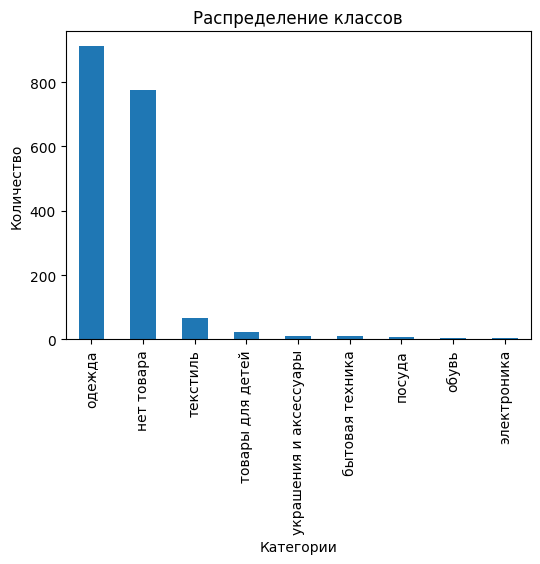

In [5]:
plt.figure(figsize=(6,4))
df['label'].value_counts().plot(kind='bar')
plt.title("Распределение классов")
plt.xlabel("Категории")
plt.ylabel("Количество")
plt.show()

# TF-IDF + SVD + LinearSVC (Решаем проблему дисбаланса классов)

Выбрали связку TF-IDF + SVD + LinearSVC на первом этапе, потому что это:

Просто и надёжно - TF-IDF хорошо работает на текстах без сложных архитектур, а LinearSVC стабильно даёт сильный baseline.

Быстро обучается - можно быстро проверить гипотезу и запустить модель даже на CPU.

Интерпретируемо - легко понимать, какие слова влияют на классификацию.

Устойчиво на малых данных - в отличие от LLM и нейросетей, методика не требует больших датасетов.

In [6]:
df = df.dropna(subset=['text','label']).reset_index(drop=True)

#чистим текст

import re

def clean_text(text):
    text = str(text).lower()  
    text = re.sub(r'\r|\n', ' ', text)  
    text = re.sub(r'[^а-яa-z0-9\s]', ' ', text)  
    text = re.sub(r'\s+', ' ', text).strip()  
    return text

df['clean_text'] = df['text'].apply(clean_text)

# Делим данные на train / val
X = df['clean_text'].values
y = df['label'].values

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# TF-IDF векторизация.

tfidf = TfidfVectorizer(max_features=30000, ngram_range=(1,2))  # учитываем слова и биграммы
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)

print("Размерность train:", X_train_tfidf.shape)

# Уменьшаем размерность (SVD)


#Поэтому уменьшим размерность (например, до 500 признаков):

svd = TruncatedSVD(n_components=500, random_state=42)
X_train_svd = svd.fit_transform(X_train_tfidf)
X_val_svd = svd.transform(X_val_tfidf)

# Обучаем модель

from sklearn.svm import LinearSVC
clf = LinearSVC(class_weight="balanced", random_state=42)
clf.fit(X_train_svd, y_train)

# Проверяем качество

y_pred = clf.predict(X_val_svd)

print("Weighted F1:", f1_score(y_val, y_pred, average='weighted'))
print(classification_report(y_val, y_pred, zero_division=0))

Размерность train: (1454, 16746)
Weighted F1: 0.7438478543428094
                        precision    recall  f1-score   support

       бытовая техника       0.00      0.00      0.00         2
            нет товара       0.75      0.74      0.74       155
                 обувь       0.00      0.00      0.00         1
                одежда       0.82      0.85      0.83       182
                посуда       0.00      0.00      0.00         2
              текстиль       0.25      0.29      0.27        14
      товары для детей       0.00      0.00      0.00         5
украшения и аксессуары       0.00      0.00      0.00         2
           электроника       0.00      0.00      0.00         1

              accuracy                           0.75       364
             macro avg       0.20      0.21      0.20       364
          weighted avg       0.74      0.75      0.74       364



Weighted F1: 0.74 - довольно неплохо для базовой модели.


Визуализация 

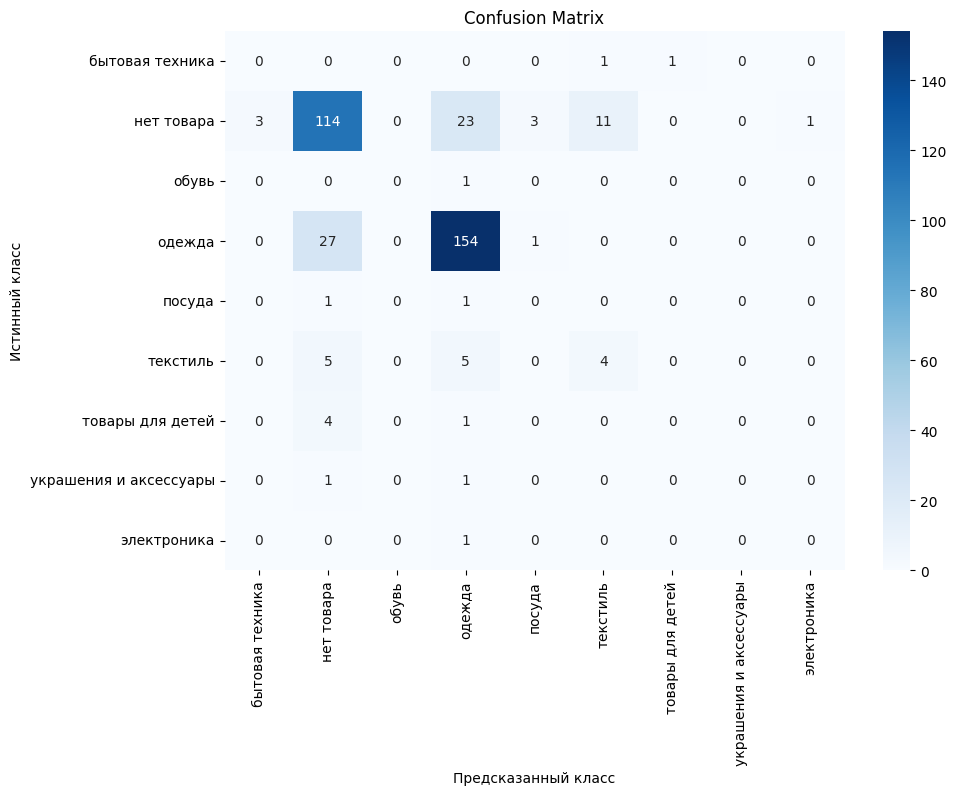

In [21]:
# Считаем матрицу ошибок
cm = confusion_matrix(y_val, y_pred, labels=clf.classes_)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=clf.classes_,
            yticklabels=clf.classes_)

plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.title("Confusion Matrix")
plt.show()

Мы видим, что модель хорошо предсказывает доминирующие классы "Одежда" и "Нет Товара", которые являются доминирующими. Однако, так как очень мало примеров других категорий, то такая простая модель не может научиться их точно предсказывать.

Однако если мы говорим про бизнес-смысл, то очевидно, что нам важно чтобы модель справлялась с классификацией отзывов, которых у нас больше всего, а "одежду", она классифицирует неплохо

# Выбор лучшей модели для обучения

Попробуем несколько моделей и выберем лучшую по метрике **Weighted F1**

In [8]:
# Кодируем метки
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)

results = []

# 1) Naive Bayes
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train_enc)
y_pred_nb = nb.predict(X_val_tfidf)
results.append({
    "Model": "Naive Bayes",
    "Weighted F1": f1_score(y_val_enc, y_pred_nb, average="weighted")
})

# 2) Logistic Regression
lr = LogisticRegression(max_iter=1000, class_weight="balanced")
lr.fit(X_train_tfidf, y_train_enc)
y_pred_lr = lr.predict(X_val_tfidf)
results.append({
    "Model": "Logistic Regression",
    "Weighted F1": f1_score(y_val_enc, y_pred_lr, average="weighted")
})

# 3) Linear SVC
svc = LinearSVC(class_weight="balanced")
svc.fit(X_train_tfidf, y_train_enc)
y_pred_svc = svc.predict(X_val_tfidf)
results.append({
    "Model": "Linear SVC",
    "Weighted F1": f1_score(y_val_enc, y_pred_svc, average="weighted")
})

# 4) Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")
rf.fit(X_train_tfidf, y_train_enc)
y_pred_rf = rf.predict(X_val_tfidf)
results.append({
    "Model": "Random Forest",
    "Weighted F1": f1_score(y_val_enc, y_pred_rf, average="weighted")
})

# 5) XGBoost
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric="mlogloss"
)
xgb.fit(X_train_tfidf, y_train_enc)
y_pred_xgb = xgb.predict(X_val_tfidf)
results.append({
    "Model": "XGBoost",
    "Weighted F1": f1_score(y_val_enc, y_pred_xgb, average="weighted")
})

# 6) CatBoost
cat = CatBoostClassifier(
    iterations=300,
    learning_rate=0.1,
    depth=6,
    random_state=42,
    verbose=0
)
cat.fit(X_train_tfidf, y_train_enc)
y_pred_cat = cat.predict(X_val_tfidf)
results.append({
    "Model": "CatBoost",
    "Weighted F1": f1_score(y_val_enc, y_pred_cat, average="weighted")
})

# Сравниваем модели
df_results = pd.DataFrame(results).sort_values(by="Weighted F1", ascending=False)
print(df_results)


                 Model  Weighted F1
4              XGBoost     0.766948
5             CatBoost     0.741945
2           Linear SVC     0.736892
3        Random Forest     0.710242
1  Logistic Regression     0.701820
0          Naive Bayes     0.672145


Финальное обучение

Лучшая модель по Weighted F1 - XGBoost. Выбираем именно её

# Обучение модели XGBoost

In [9]:
# 1. Загружаем размеченный train
df = pd.read_csv('/kaggle/input/train-labeled/train_labeled.csv')
df = df.dropna(subset=['text','label']).reset_index(drop=True)

# 2. Чистим текст

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\r|\n', ' ', text)
    text = re.sub(r'[^а-яa-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['clean_text'] = df['text'].apply(clean_text)

X_train = df['clean_text'].values
y_train = df['label'].values


# 3. TF-IDF + SVD

tfidf = TfidfVectorizer(max_features=30000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)

# Уменьшение размерности для ускорения обучения
svd = TruncatedSVD(n_components=300, random_state=42)
X_train_svd = svd.fit_transform(X_train_tfidf)


# 4. Финальная модель (XGBoost)

xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

from sklearn.preprocessing import LabelEncoder

# Кодируем метки
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)  # строки -> числа

xgb.fit(X_train_svd, y_train_enc)


# 5. Сохраняем модель и преобразователи

with open('xgb_final_model.pkl', 'wb') as f:
    pickle.dump({
        'model': xgb,
        'tfidf': tfidf,
        'svd': svd,
        'le': le   
    }, f)

Проверка скорости инференса

In [10]:
test_texts = [
    "Классная футболка, размер подошёл.",
    "Доставка ужасная, товар не пришёл.",
    "Очень красивое кольцо с камнем, блестит!"
]

start_time = time.time()
X_test_tfidf = tfidf.transform(test_texts)
X_test_svd = svd.transform(X_test_tfidf)
y_pred_enc = xgb.predict(X_test_svd)
y_pred_test = le.inverse_transform(y_pred_enc)  # обратно в категории
end_time = time.time()

print("Предсказания:", y_pred_test)
print(f"Среднее время на один отзыв: {(end_time - start_time)/len(test_texts):.3f} сек")

Предсказания: ['одежда' 'нет товара' 'нет товара']
Среднее время на один отзыв: 0.004 сек


Видим довольно высокую скорость классификации (0.004< 5). Где 5 сек - порог по заданию.

Тут видим, что модель правильно классифицирует отзыв с одеждой и отзыв, где нет товара. Однако, когда речь идет о категории "Украшения и аксессуары", то модель размечает, как "нет товара". Опять же это происходит из-за того, что отзывово такого класса очень мало.

# Оценка на тестовом наборе

In [11]:
# 1. Загружаем модель и преобразователи

with open('xgb_final_model.pkl', 'rb') as f:
    data = pickle.load(f)

xgb = data['model']
tfidf = data['tfidf']
svd = data['svd']
le = data['le']

# 2. Загружаем тестовый датасет

test_df = pd.read_csv('/kaggle/input/test-df/test (2).csv')  # путь к тесту
test_df = test_df.dropna(subset=['text']).reset_index(drop=True)


# 3. Чистим текст

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\r|\n', ' ', text)
    text = re.sub(r'[^а-яa-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

test_df['clean_text'] = test_df['text'].apply(clean_text)

# 4. Преобразуем текст и делаем предсказания

start_time = time.time()
X_test_tfidf = tfidf.transform(test_df['clean_text'])
X_test_svd = svd.transform(X_test_tfidf)
y_test_pred = xgb.predict(X_test_svd)
end_time = time.time()

# Обратно в текстовые категории
y_pred_labels = le.inverse_transform(y_test_pred)

print(f"Среднее время на один отзыв: {(end_time - start_time)/len(test_df):.8f} сек")

Среднее время на один отзыв: 0.00004678 сек


Видим что, среднее время на классификацию одного отзывы (0.00004678 сек > 5 cек) проходит порог указанный в задании.

Сохраняем предсказания в CSV

In [24]:
submission = pd.DataFrame({
    'text': test_df['text'],
    'predicted_label': y_pred_labels
})
submission.to_csv('/kaggle/working/test_predictions.csv', index=False)

Смотрим на распределение категорий в тестовом датасете

In [27]:
submission['predicted_label'].value_counts()

predicted_label
одежда        3656
нет товара    3617
текстиль         3
Name: count, dtype: int64

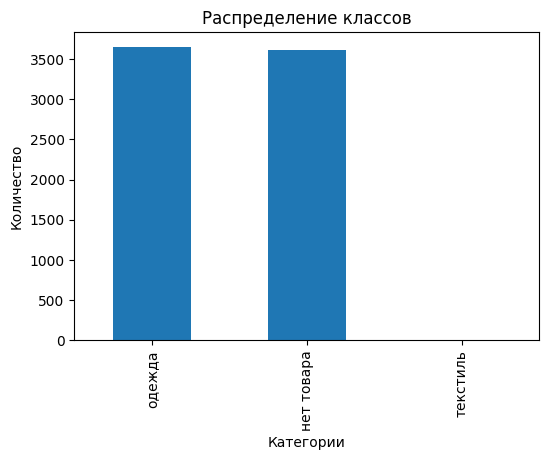

In [26]:
plt.figure(figsize=(6,4))
submission['predicted_label'].value_counts().plot(kind='bar')
plt.title("Распределение классов")
plt.xlabel("Категории")
plt.ylabel("Количество")
plt.show()

Видим, что на тестовом датасете модель совсем не учитывает очень редкие категории.

Это trade-off, который мы выбрали. Модель простая и быстрая, хорошо справляется с классификацией самых частотных категорий. Но для более точной классификации в будущем можно использовать более сложные модели в том числе LLM.